## Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


### Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
try:
    import google.colab
    !git clone https://github.com/marcusklasson/GroceryStoreDataset.git
except: pass

In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [4]:
# ! python3 -m pip install --upgrade pip
! pip install -q wandb
! pip install -q torchmetrics
! pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 41.4 MB/s eta 0:00:00


### Weights and Biases for following the net

In [4]:
import wandb

WANDB_USER = "davidecrociati"
WANDB_PROJECT = "assignments part two"

### Imports

In [5]:
# Standard library imports
import csv
import copy
import random
from pathlib import Path
from typing import Any, Dict
import os
import json
from datetime import datetime
import time

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR
from torch.utils.data import DataLoader
import torch.utils
from torchmetrics.classification.accuracy import Accuracy
from torchsummary import summary

# Torchvision imports
from torchvision import transforms as T
from torchvision.models import resnet18, ResNet18_Weights

### Functions

In [8]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def extract_classes(csv_file_path: str) -> dict:
    """
    Extract unique pairs of IDs and labels from a CSV file.

    This function reads a CSV file, extracts the third and fourth columns,
    and creates a dictionary with unique pairs of IDs (from the fourth column)
    and labels (from the third column).

    Parameters:
    csv_file_path (str): The path to the CSV file.

    Returns:
    dict: A dictionary with IDs as keys and labels as values.
    """

    # Dictionary to store the unique pairs
    classes = {}

    # Read the CSV file
    with open(csv_file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        # Skip the CSV header
        next(csv_reader)

        for row in csv_reader:
            label = row[2]       # Third column
            id = int(row[3])     # Fourth column

            # Add the pair to the dictionary if it doesn't already exist
            if id not in classes:
                classes[id] = label

    return classes

def show_grid(dataset: GroceryStoreDataset, classes: dict) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(classes.keys()))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        item = dataset.__getitem__(idx) # (Tensor, idx)
        title = classes[item[1]]
        plt.title(title)
        image_processed = item[0]
        plt.imshow(T.ToPILImage()(image_processed))
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def parse_compose(v):
  res = []
  for t in str(v).split("\n")[1:]:
    res.append(t.strip("    "))
  return res[:-1]

### Configuration

In [7]:
fix_random(seed=42)

device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

cfg = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 20,
    "optimizer":Adam,
    "optimizer_params":{
      "lr": 1e-3,
    },
    "scheduler":None,
    "scheduler_params":{},
    "step_size": 5
}

All good, a GPU is available


### Data

#### Dataset

In [9]:
# In  order to convert integer classes into their literal
classes = extract_classes(csv_file_path = 'GroceryStoreDataset/dataset/classes.csv')

cfg["augment"] = True   # True/False
data_transforms = {
    "train": T.Compose([
                        T.Resize((cfg["crop_size"],cfg["crop_size"])),
                        T.ToTensor()
                    ]),

    "val": T.Compose([
                        T.Resize((cfg["crop_size"],cfg["crop_size"])),
                        T.ToTensor()
                    ]),

    "test": T.Compose([
                        T.Resize((cfg["crop_size"],cfg["crop_size"])),
                        T.ToTensor()
                    ])
}

# Datasets
data_train = GroceryStoreDataset(split="train", transform=data_transforms["train"] if cfg["augment"] else None)
data_val = GroceryStoreDataset(split="val", transform=data_transforms["val"])
data_test = GroceryStoreDataset(split="test", transform=data_transforms["test"])

#### Augmented dataset

In [10]:
cfg["augment"] = True   # True/False
data_transforms = {
    "train": T.Compose([
                        T.RandomResizedCrop(cfg["crop_size"]),
                        T.RandomHorizontalFlip(),
                        T.RandomVerticalFlip(),
                        T.RandomRotation(180),                              # rotation in all directions
                        T.RandomAffine(degrees=0, translate=(0.1, 0.1)),    # translations of 10%
                        T.RandomPerspective(distortion_scale=0.1, p=0.5),
                        T.ToTensor(),
                    ]),

    "val": T.Compose([
                        T.Resize(cfg["crop_size"]),
                        T.ToTensor(),
                    ]),

    "test": T.Compose([
                        T.Resize(cfg["crop_size"]),
                        T.ToTensor()
                    ])
}

# Datasets
data_train_augm = GroceryStoreDataset(split="train", transform=data_transforms["train"] if cfg["augment"] else None)
data_val_augm = GroceryStoreDataset(split="val", transform=data_transforms["val"])
data_test_augm = GroceryStoreDataset(split="test", transform=data_transforms["test"])

In [11]:
# For automating batching

loader_train = DataLoader(
    data_train,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val = DataLoader(
    data_val,
    batch_size=cfg["batch_size"],
    shuffle=False
)
loader_test = DataLoader(
    data_test,
    batch_size=cfg["batch_size"],
    shuffle=False
)

loader_train_augm = DataLoader(
    data_train_augm,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
loader_val_augm = DataLoader(
    data_val_augm,
    batch_size=cfg["batch_size"],
    shuffle=False
)
loader_test_augm = DataLoader(
    data_test_augm,
    batch_size=cfg["batch_size"],
    shuffle=False
)

#### Classes Distribution

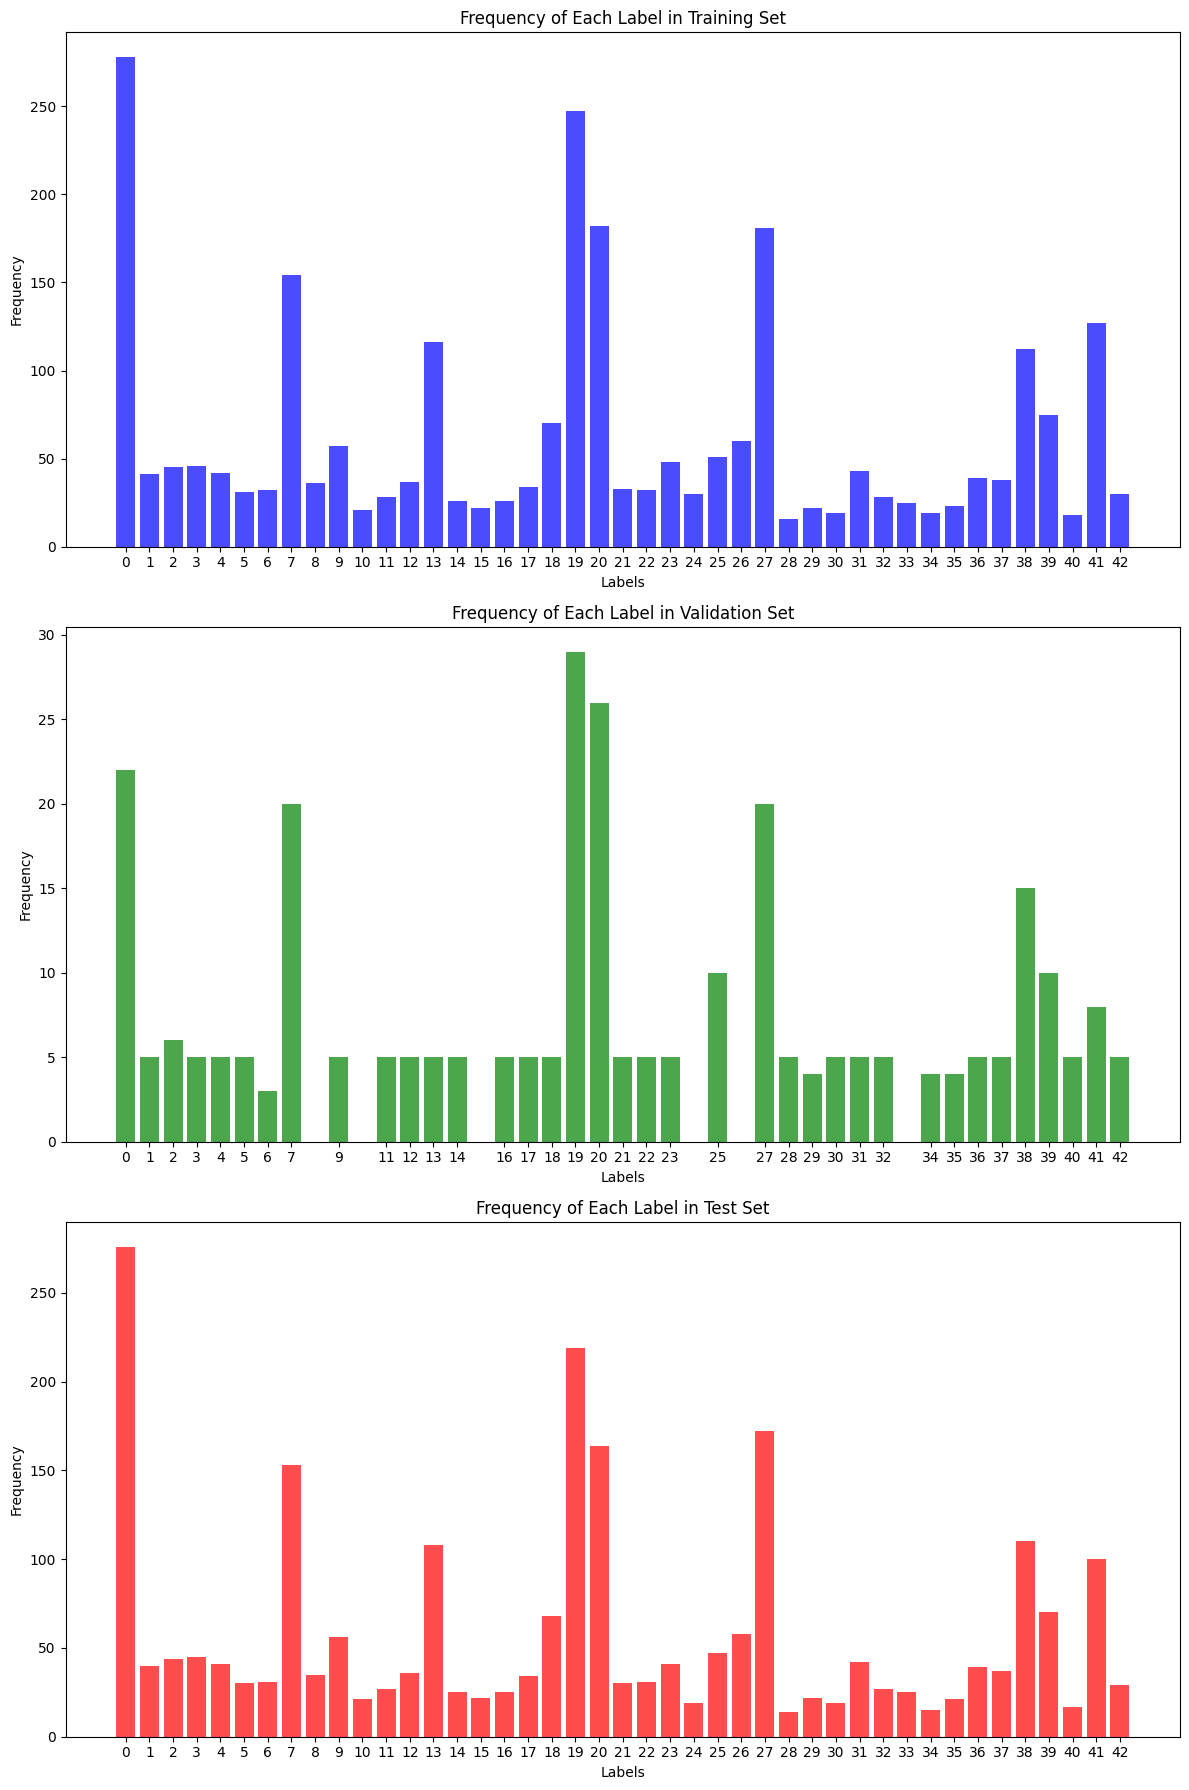

In [12]:
train_labels, train_counts = np.unique(data_train_augm.labels, return_counts=True)
val_labels, val_counts = np.unique(data_val_augm.labels, return_counts=True)
test_labels, test_counts = np.unique(data_test_augm.labels, return_counts=True)

# Creating the figure and axes for the three bar plots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plotting the training set bar chart
axs[0].bar(train_labels, train_counts, color='blue', alpha=0.7)
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency of Each Label in Training Set')
axs[0].set_xticks(train_labels)

# Plotting the validation set bar chart
axs[1].bar(val_labels, val_counts, color='green', alpha=0.7)
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency of Each Label in Validation Set')
axs[1].set_xticks(val_labels)

# Plotting the test set bar chart
axs[2].bar(test_labels, test_counts, color='red', alpha=0.7)
axs[2].set_xlabel('Labels')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Frequency of Each Label in Test Set')
axs[2].set_xticks(test_labels)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

### Trainer

In [26]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            configuration: dict,
            train_loader: DataLoader,
            val_loader: DataLoader,
            test_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.cfg=configuration
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = self.cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = self.cfg["optimizer"](self.model.parameters(), **self.cfg["optimizer_params"])
        num_steps = self.num_epochs * len(train_loader)
        if self.cfg["scheduler"]:
            self.scheduler = self.cfg["scheduler"](self.optimizer, 
                                                   self.cfg["optimizer_params"]["lr"], 
                                                   total_steps=num_steps, 
                                                   **self.cfg["scheduler_params"]
                                                   )#    , pct_start=0.25)

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=self.cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=self.cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        self.training_time = time.time()
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                # print(pred.shape, labels.shape)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if self.cfg["scheduler"]:
                    self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    if self.cfg["scheduler"]:
                        self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})
                    else:
                        self.logfn({"train/lr": self.cfg["optimizer_params"]["lr"]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()
        self.training_time = time.time() - self.training_time


    # def test(self) -> None:
    #     wandb.init(name=cfg["run_name"]+"_test", entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)
    #     self.eval("test")
    #     wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        if split == "train":
            loader = self.train_loader
        elif split == "val":
            loader = self.val_loader
        # elif split == "test":
        #     loader = self.test_loader
        else:
            raise ValueError(f"Unknown split: {split}")

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        self.logfn({f"{split}/loss": loss})
        self.logfn({f"{split}/acc": accuracy})

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

    def save_model_params(self, data_transforms):
        model_dir = os.path.join("params", f"{self.cfg['model']}_model")
        os.makedirs(model_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")  # in order not to have duplicates
        training_time_formatted = time.strftime('%H-%M-%S', time.gmtime(self.training_time))
        file_name = f"ACC={self.best_acc:.2f}____TT={training_time_formatted}____TM={timestamp}.json"
        file_path = os.path.join(model_dir, file_name)

        cfg={c:str(self.cfg[c]) for c in self.cfg}
        combined_params = {
            "cfg": cfg,
            "data_transforms": {k: parse_compose(v) for k,v in data_transforms.items()},
            "model_structure" : parse_compose(self.model)
        }

        with open(file_path, 'w') as f:
            json.dump(combined_params, f, indent=4)

### Models

#### V1

In [26]:
class ProjectCNN_v1(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(ProjectCNN_v1, self).__init__()
        self.input_dim=input_dim

        ## Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=3) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
                                                                
        self._to_linear = None
        self._set_conv_output_size()
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def _set_conv_output_size(self):
        x = torch.randn(1, 3, *self.input_dim)
        x=self._forward(x)
        self._to_linear = x.numel()

    def _forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        return x

    def forward(self, x):
        x=self._forward(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
model = ProjectCNN_v1(n_classes=len(classes),input_dim=(cfg["crop_size"], cfg["crop_size"]))
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           4,736
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 28, 28]          51,264
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Linear-5                  [-1, 128]       1,605,760
            Linear-6                   [-1, 43]           5,547
Total params: 1,667,307
Trainable params: 1,667,307
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.31
Params size (MB): 6.36
Estimated Total Size (MB): 11.24
----------------------------------------------------------------


In [32]:
cfg["run_name"] = "v1"

trainer = Trainer(
    model,
    cfg,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
# trainer.save_model_params(data_transforms)

train/acc,▁▄▅▆▇█████
train/loss,█▇▆▅▅▄▅▄▄▃▃▃▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▂▃█▅▇▅▆▁▇▅
val/loss,▂▂▁▂▂▄▄▆▆█
train/acc,0.96932
train/loss,0.13944
train/lr,0.001
val/acc,0.26351
val/loss,5.46709


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train/acc,▁▃▅▆▇▇▇█████████████
train/loss,█▇▆▅▅▄▃▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▃▁▄▄▆▆███▇▅▅▄▄▆▅▅▅▅▅
val/loss,▁▂▁▂▂▂▅▄▄▅▆▅▇█▆▇████
train/acc,1.0
train/loss,0.00034
train/lr,0.001
val/acc,0.26014
val/loss,6.1368


Best val acc = 0.324


#### V2

In [54]:
class ProjectCNN_v2(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(ProjectCNN_v2, self).__init__()
        self.input_dim=input_dim

        # Stem Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=1) 

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  

        # Convolutional layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)

                                                                
        self._to_linear = None
        self._set_conv_output_size()
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _set_conv_output_size(self):
        x = torch.randn(1, 3, *self.input_dim)
        x=self._forward(x)
        self._to_linear = x.numel()

    def _forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x

    def forward(self, x):
        x = self._forward(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [63]:
model = ProjectCNN_v2(n_classes=len(classes),input_dim=(cfg["crop_size"], cfg["crop_size"]))
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 110, 110]           4,736
         MaxPool2d-2           [-1, 32, 55, 55]               0
            Conv2d-3           [-1, 64, 55, 55]          18,496
            Conv2d-4          [-1, 128, 28, 28]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
            Conv2d-6            [-1, 512, 7, 7]       1,180,160
            Linear-7                  [-1, 512]      12,845,568
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 43]          11,051
Total params: 14,560,363
Trainable params: 14,560,363
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 6.52
Params size (MB): 55.54
Estimated Total Size (MB): 62.63
-----------------------------------

In [66]:
cfg["run_name"] = "v2.2+50-epochs_wd_augm"
# cfg["scheduler"] = None
# cfg["scheduler_params"] = {"pct_start":0.25}
cfg["num_epochs"]=50
cfg["optimizer"]=AdamW
cfg["optimizer_params"]["lr"]=0.001
cfg["optimizer_params"]["weight_decay"]=5e-3
# display(cfg)

In [67]:
trainer = Trainer(
    model,
    cfg,
    loader_train_augm,
    loader_val_augm,
    loader_test_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
# trainer.save_model_params(cfg, data_transforms)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train/acc,▂▁▁▁▂▁▂▃▃▄▂▃▄▅▅▃▅▄▅▅▃▆▄▅▄▆▆▅▆▅▆▇▇▇▇███▇▇
train/loss,▅▄▃▅▃▃▅▄▂▅▄▄▃▅▄▄▂▄▃▂▃▄▄▃▄▃▃▅▃▁▃▃▂▃▃▃▂▃▃█
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▃▅▃▄▃▁▃▄▆▄▂▆▄▃▅▃▅▅▄▅▄▆▅▆▂▄▄▆▆▇▅▆▅▅▆█▇█▆▆
val/loss,▄▂▅▃▄▆▅▁▃▃▄▂▄▄▂▄▄▃▅▂▃▂▃▂█▄▄▁▃▂▄▄▄▅▃▂▄▃▅▃
train/acc,0.73485
train/loss,0.81287
train/lr,0.001
val/acc,0.44932
val/loss,2.11496


Best val acc = 0.503


: 

#### Resnet senza bn

In [14]:
class ProjectCNN_v3(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(ProjectCNN_v3, self).__init__()
        self.input_dim=input_dim

        K,S,P=3,1,1

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=K, stride=S, padding=P)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=K, stride=S, padding=P)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=K, stride=2, padding=P)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=K, stride=S, padding=P)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=K, stride=2, padding=P)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=K, stride=S, padding=P)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=K, stride=2, padding=P)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=K, stride=S, padding=P)


        self.globalpool = nn.AvgPool2d(kernel_size=7)

        self._to_linear = None
        self._set_conv_output_size()
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _set_conv_output_size(self):
        x = torch.randn(1, 3, *self.input_dim)
        x=self._forward(x)
        self._to_linear = x.numel()

    def _forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))  # 32 x 112 x 112
        x = self.conv2(x)
        x = self.conv3(F.relu(x))
        x = self.conv4(F.relu(x))
        x = self.conv5(F.relu(x))
        x = self.conv6(F.relu(x))
        x = self.conv7(F.relu(x))
        x = self.conv8(F.relu(x))
        x = self.conv9(F.relu(x))
        # x = F.relu(x)  # 512 x 7 x 7
        x = self.globalpool(F.relu(x))  # 512 x 7 x 7
        return x

    def forward(self, x):
        x=self._forward(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = ProjectCNN_v3(n_classes=len(classes),input_dim=(cfg["crop_size"], cfg["crop_size"]))
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,472
         MaxPool2d-2           [-1, 64, 55, 55]               0
            Conv2d-3           [-1, 64, 55, 55]          36,928
            Conv2d-4           [-1, 64, 55, 55]          36,928
            Conv2d-5          [-1, 128, 28, 28]          73,856
            Conv2d-6          [-1, 128, 28, 28]         147,584
            Conv2d-7          [-1, 256, 14, 14]         295,168
            Conv2d-8          [-1, 256, 14, 14]         590,080
            Conv2d-9            [-1, 512, 7, 7]       1,180,160
           Conv2d-10            [-1, 512, 7, 7]       2,359,808
        AvgPool2d-11            [-1, 512, 1, 1]               0
           Linear-12                  [-1, 512]         262,656
           Linear-13                  [-1, 256]         131,328
           Linear-14                   

In [16]:
cfg["num_epochs"]=50
display(cfg)

{'resize_size': 256,
 'crop_size': 224,
 'batch_size': 32,
 'num_epochs': 50,
 'optimizer': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.001},
 'scheduler': None,
 'scheduler_params': {},
 'step_size': 5,
 'augment': True}

In [17]:
cfg["run_name"] = "v3"

# Wandb key: 301c5db1df292fea814603255510519eb6564aff

trainer = Trainer(
    model,
    cfg,
    loader_train_augm,
    loader_val_augm,
    loader_test_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
# trainer.save_model_params(cfg, data_transforms)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: davidesonno (davidecrociati). Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Resnet senza res ma con BN

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProjectCNN_v3_BN(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(ProjectCNN_v3_BN, self).__init__()
        self.input_dim = input_dim

        K, S, P = 3, 1, 1

        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=P)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=K, stride=S, padding=P)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=K, stride=S, padding=P)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=K, stride=2, padding=P)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=K, stride=S, padding=P)
        self.bn5 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=K, stride=2, padding=P)
        self.bn6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=K, stride=S, padding=P)
        self.bn7 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=K, stride=2, padding=P)
        self.bn8 = nn.BatchNorm2d(512)

        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=K, stride=S, padding=P)
        self.bn9 = nn.BatchNorm2d(512)

        self.globalpool = nn.AvgPool2d(kernel_size=7)

        self._to_linear = None
        self._set_conv_output_size()
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _set_conv_output_size(self):
        x = torch.randn(1, 3, *self.input_dim)
        x = self._forward(x)
        self._to_linear = x.numel()

    def _forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 64 x 112 x 112
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.globalpool(x)  # 512 x 7 x 7
        return x

    def forward(self, x):
        x = self._forward(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [27]:
model = ProjectCNN_v3_BN(n_classes=len(classes),input_dim=(cfg["crop_size"], cfg["crop_size"]))
if next(model.parameters()).device != device:
    model.to(device)
summary(
    model,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,472
       BatchNorm2d-2         [-1, 64, 110, 110]             128
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 64, 55, 55]          36,928
       BatchNorm2d-5           [-1, 64, 55, 55]             128
            Conv2d-6           [-1, 64, 55, 55]          36,928
       BatchNorm2d-7           [-1, 64, 55, 55]             128
            Conv2d-8          [-1, 128, 28, 28]          73,856
       BatchNorm2d-9          [-1, 128, 28, 28]             256
           Conv2d-10          [-1, 128, 28, 28]         147,584
      BatchNorm2d-11          [-1, 128, 28, 28]             256
           Conv2d-12          [-1, 256, 14, 14]         295,168
      BatchNorm2d-13          [-1, 256, 14, 14]             512
           Conv2d-14          [-1, 256,

In [28]:
cfg["num_epochs"] = 2
cfg["run_name"] = "v3_fun_test"

# Wandb key: 301c5db1df292fea814603255510519eb6564aff
trainer = Trainer(
    model,
    cfg,
    loader_train_augm,
    loader_val_augm,
    loader_test_augm,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc = {trainer.best_acc:.3f}")
# Log results
trainer.save_model_params(data_transforms)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

train/acc,▁█
train/loss,█▇▅▄▄▄▄▁▅▆▁▂▃▄▃▂▃▂▃
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁█
val/loss,█▁
train/acc,0.20303
train/loss,2.80912
train/lr,0.001
val/acc,0.22973
val/loss,3.1335


Best val acc = 0.230


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### 1) Fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [ ]:
# Pretrained ResNet-18 on ImageNet-1K (V1)
pt_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Davide/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.66MB/s]


In [ ]:
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

## First train
cfg["run_name"] = "ResNet-18_pretrained_scratch-training"
## cfg["num_epochs"] = 5
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▁▄▅▆▇▇▇███
train/loss,█▅▅▃▃▃▄▂▂▃▃▂▂▂▂▂▃▂▂▁▂▂▂▃▁▁▂▂▂▂▂▁▂▂▂▁▂▂▂▃
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▄▅▆▇▆█▇▇█
val/loss,█▅▃▂▂▂▁▁▁▁
train/acc,0.82197
train/loss,0.61639
train/lr,0.001
val/acc,0.70946
val/loss,0.94376


In [ ]:
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Best val acc (intermediate) = 0.723


In [ ]:
## Load the state of the best accuracy
sd = torch.load(f"ckpts/{cfg['run_name']}.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

## Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▁▄▅▇▅▇▆▆██
train/loss,▇▅█▆▄▃▃▃▄▃▄▂▂▁▂▄▃▃▁▅▃▄▄▁▃▂▁▁▂▆▃▂▂▂▃▁▂▂▂▂
train/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▄▇▇▃▅▇█▆▇
val/loss,▇▆▅▃█▅▂▂▅▁
train/acc,0.97197
train/loss,0.09855
train/lr,0.0001
val/acc,0.86824
val/loss,0.40012


In [ ]:
print(f"Best val acc (final) = {trainer.best_acc:.3f}")

Best val acc (final) = 0.878


### 2) Tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`.

In [ ]:
# You need to do the same but with different cfg
cfg_fine_tuning = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 16,
    "num_epochs": 30,
    "lr": 1e-3,
    "wd": 5e-4,
    "step_size": 5,
    'scheduled':True
}
cfg = cfg_fine_tuning

In [ ]:
## Freeze the pre-trained layers ##
for param in pt_resnet18.parameters():
    param.requires_grad = False

## Modify the last layer ##
pt_resnet18.fc = torch.nn.Linear(pt_resnet18.fc.in_features, len(classes.keys()))

# First train
cfg["run_name"] = "ResNet-18_pretrained_scratch-training_2"
# cfg["num_epochs"] = 5
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (intermediate) = {trainer.best_acc:.3f}")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Load the state of the best accuracy
sd = torch.load(f"ckpts/{cfg['run_name']}.pt")
pt_resnet18.load_state_dict(sd)

## Activate learning
for param in pt_resnet18.parameters():
    param.requires_grad = True

# Fine tuning
cfg["run_name"] = "ResNet-18_pretrained_fine-tuning_2"
cfg["lr"] *= 0.1
cfg["num_epochs"] = 10
trainer = Trainer(
    pt_resnet18,
    loader_train,
    loader_val,
    loader_test,
    device,
    num_classes=len(classes.keys())
)
trainer.train()
print(f"Best val acc (final) = {trainer.best_acc:.3f}")